# Review of scikit-learn via the Kaggle Leaf Classification competition
One of the Kaggle "Playground" competitions involves image based leaf identification. It's a great competition for reviewing how to use scikit-learn (sklearn, for short) and various statistical/machine learning techniques for an important classification problem. It also lets us review a little numpy, pandas and matplotlib.

Let's start by checking out the details of the competition.

https://www.kaggle.com/c/leaf-classification

I've already downloaded the data and let's check that out now too. 

* `data/` - folder containing the test and train data in csv format
& `images/` - folder containing the leaf images

A couple things to note about this problem:

* There are quite a few numeric features (192 predictor columns) but we really don't know exactly how they were computed nor what they mean other than that they describe the margin, shape, and texture of the leaves.
* We can get started by simply using these 192 input variables and NOT doing any image analysis ourselves. Later, we can push ourselves to generate our own features doing our own image analysis.
* It's NOT a binary classification problem. There are 99 leaf classes with 10 samples per class.
* The contest does NOT want binary predictions for each sample, but instead wants probabilities for each sample being in each of the 99 classes. We'll see that sklearn makes it easy to predict either classes or probabilities.

This notebook has multiple learning objectives related to Python, modeling, installing software, using external libraries and tools and more.

* Basic review of sklearn (and some numpy, pandas, and matplotlib)
* Checking out the notebooks for the PDSH book (extremely good)
* Creating numpy arrays from pandas dataframes
* The sklearn estimator API workflow (not using Pipeline objects till later in module)
* Visualizing matrices and decision trees
* Quickly fitting and scoring multiple types of ML models
* Submitting entries to a Kaggle competition
* Combining models into an ensemble model using voting classifiers

## Intro to scikit-learn from Python Data Science Handbook

Let's start by reviewing part of Jake Vanderplas' notebook entitled `05.02-Introducing-Scikit-Learn.ipynb` from the [PDSH set of notebooks](https://github.com/jakevdp/PythonDataScienceHandbook) (which you should have already downloaded when you were setting up your machine for this course). This book and associated notebooks are a fantastic resource for learning to effectively use Jupyter notebooks (Ch1), numpy (Ch2), pandas (Ch3), matplotlib (Ch4) and scikit-learn (Ch5). 

In particular, we'll review how to represent data in scikit-learn and the basic estimator API for fitting and using statistical/machine learning models.

In addition, the [sklearn Getting Started guide](https://scikit-learn.org/stable/getting_started.html) gives a concise high level overview of using 

**TODO** **Create screencast for intro to sklearn in JVP and touching on the Getting Started page**

## Getting started with the Leaf Classification problem

Let's do our standard pandas, numpy and matplotlib imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

We are also going to need the `mpimg` submodule from matplotlib. You can find a nice [image tutorial for matplotlib here](https://matplotlib.org/stable/tutorials/introductory/images.html).

In [2]:
import matplotlib.image as mpimg

Need the standard magic command so our plots are displayed inline in the notebook.

In [3]:
%matplotlib inline

In order to use matplotlib with anything other than PNG images, we need to install Pillow. Let's check if it's installed.

In [4]:
# Linux or mac
# conda list | grep 'pillow'

# Windows Anaconda command prompt
# conda list | findstr "pillow"

In [5]:
# I've already installed it
#!conda install pillow

Let's look at a few random pics. I've heavily commented this code to serve as a bit of a matplotlib review.

[1100, 526, 666]
['./images/1100.jpg', './images/526.jpg', './images/666.jpg']


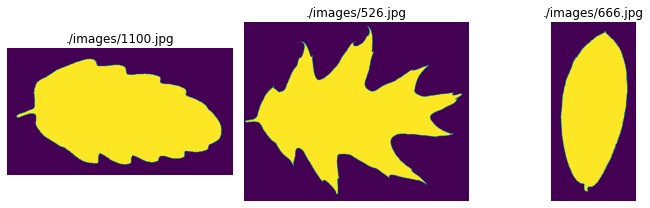

In [6]:
# Choose three random numbers between 0 and 1499. These will correspond to picture filenames.
picnums = list(np.random.randint(1500, size=3))
print(picnums)

# Notice the use of a simple list comprehension to get a list of filenames with paths
paths_to_pics = ['./images/'+str(picnum)+'.jpg' for picnum in picnums]
print(paths_to_pics)

# Create an empty figure object with matplotlib and set the figure size
plt.figure(figsize=(10.0, 3.0))

# Loop over a range of ints to use as index nums for the pic list
for i in range(3):
    img = mpimg.imread(paths_to_pics[i]) # Read the image
    plt.subplot(1, 3, i + 1)             # Add a new subplot to our figure (1 row by 3 cols and this is i+1)
    plt.axis('off')                      # Supress the axes display
    plt.title(paths_to_pics[i])          # Add a title for this image
    plt.imshow(img)                      # Display the image within the subplot

plt.tight_layout()  # Tweak the subplot layout
plt.show()          # Show the entire plot

### Focus of this notebook
We are NOT going to be getting into details of different classification algorithms in this notebook. Instead, we'll see how easy it is with `scikit-learn` to try out several different classification techniques, even combining them via ensembles, and make submissions to a Kaggle competition. One of the strengths of `scikit-learn` is that it strives to have a very consistent interface no matter which technique you are using. In general, our approach will be:

* instantiate a specific classifier model object
* fit the model using our input data
* make predictions using the model for the test data
* write out a submission file for Kaggle

As you are going through this notebook, you might want to activate the integrated Table of Contents in the left sidebar. This is a new feature in Jupyter Lab 3 (it used to be an extension). Here's what it looks like:

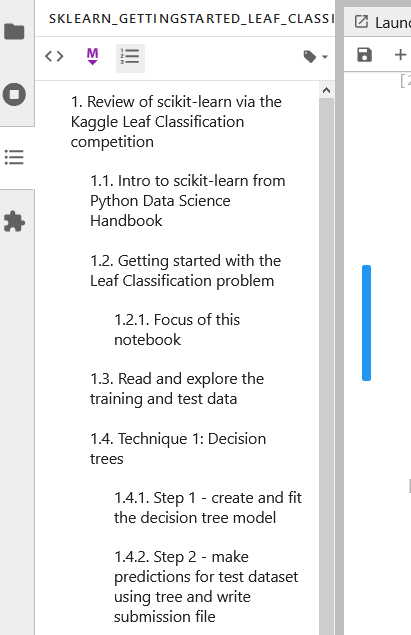

In [7]:
Image("toc.png")

## Read and explore the training and test data
Let's read the data into Pandas dataframes since we are familiar with those and it's easy to convert them to numpy arrays as needed. Since there is an `id` column in the dataset and it's the first column, we'll tell pandas to use it as the `Index` for the `DataFrame`.

In [8]:
train_df = pd.read_csv("data/train.csv", index_col=0)
test_df = pd.read_csv("data/test.csv", index_col=0)

In [9]:
train_df.head()

,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
id,,,,,,,,,,,,,,,,,,,,,
1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [10]:
train_df.tail()

,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
id,,,,,,,,,,,,,,,,,,,,,
1575,Magnolia_Salicifolia,0.060547,0.119140,0.007812,0.003906,0.000000,0.148440,0.017578,0.0,0.001953,...,0.242190,0.000000,0.034180,0.000000,0.010742,0.000000,0.000000,0.000000,0.000000,0.018555
1578,Acer_Pictum,0.001953,0.003906,0.021484,0.107420,0.001953,0.000000,0.000000,0.0,0.029297,...,0.170900,0.000000,0.018555,0.000000,0.011719,0.000000,0.000000,0.000977,0.000000,0.021484
1581,Alnus_Maximowiczii,0.001953,0.003906,0.000000,0.021484,0.078125,0.003906,0.007812,0.0,0.003906,...,0.004883,0.000977,0.004883,0.027344,0.016602,0.007812,0.000000,0.027344,0.000000,0.001953
1582,Quercus_Rubra,0.000000,0.000000,0.046875,0.056641,0.009766,0.000000,0.000000,0.0,0.037109,...,0.083008,0.030273,0.000977,0.002930,0.014648,0.000000,0.041992,0.000000,0.001953,0.002930
1584,Quercus_Afares,0.023438,0.019531,0.031250,0.015625,0.005859,0.019531,0.035156,0.0,0.003906,...,0.000000,0.000000,0.002930,0.000000,0.012695,0.000000,0.000000,0.023438,0.025391,0.022461


In [11]:
test_df.head()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
id,,,,,,,,,,,,,,,,,,,,,
4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,0.023438,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,0.023438,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,0.005859,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,0.001953,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,0.000000,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 1 to 1584
Columns: 193 entries, species to texture64
dtypes: float64(192), object(1)
memory usage: 1.5+ MB


Notice a few things:

* other than the `species` column, all of the other columns are numeric.
* the target column, `species`, is a string. We need to convert it to an integer for use with `scikit-learn`.

One nice feature of sklearn is that it includes functionality for many parts of the statistical predictive modeling workflow. In this case, we can use the `LabelEncoder` object from the `preprocessing` module to recode the target value. As you'll see from the following doc page, `LabelEncoder` is intended for use with **target** values, not for the features.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

Before just copying and pasting and editing the entire example code from the above page to accomplish the encoding, let's explore a few pieces at a time so that we see what's going on. I encourage you to do this throughout the course and beyond so that you develop an understanding of what's happening in a sequence of sklearn code lines.

In [13]:
from sklearn import preprocessing

# Create a LabelEncoder object
le = preprocessing.LabelEncoder()

# Use its fit method to fit the labels in the species column
le.fit(train_df['species'])

# Let's look at the classes that were fit
targets = list(le.classes_)
print(targets)

['Acer_Capillipes', 'Acer_Circinatum', 'Acer_Mono', 'Acer_Opalus', 'Acer_Palmatum', 'Acer_Pictum', 'Acer_Platanoids', 'Acer_Rubrum', 'Acer_Rufinerve', 'Acer_Saccharinum', 'Alnus_Cordata', 'Alnus_Maximowiczii', 'Alnus_Rubra', 'Alnus_Sieboldiana', 'Alnus_Viridis', 'Arundinaria_Simonii', 'Betula_Austrosinensis', 'Betula_Pendula', 'Callicarpa_Bodinieri', 'Castanea_Sativa', 'Celtis_Koraiensis', 'Cercis_Siliquastrum', 'Cornus_Chinensis', 'Cornus_Controversa', 'Cornus_Macrophylla', 'Cotinus_Coggygria', 'Crataegus_Monogyna', 'Cytisus_Battandieri', 'Eucalyptus_Glaucescens', 'Eucalyptus_Neglecta', 'Eucalyptus_Urnigera', 'Fagus_Sylvatica', 'Ginkgo_Biloba', 'Ilex_Aquifolium', 'Ilex_Cornuta', 'Liquidambar_Styraciflua', 'Liriodendron_Tulipifera', 'Lithocarpus_Cleistocarpus', 'Lithocarpus_Edulis', 'Magnolia_Heptapeta', 'Magnolia_Salicifolia', 'Morus_Nigra', 'Olea_Europaea', 'Phildelphus', 'Populus_Adenopoda', 'Populus_Grandidentata', 'Populus_Nigra', 'Prunus_Avium', 'Prunus_X_Shmittii', 'Pterocarya_S

Now that the encoder is fit, we use its `transform` method to apply it to our `species` column. To start with, I'm **not** going to add a new column to the dataframe. Start by just sticking the output into a variable that we can then explore and make sure things are working ok.

In [14]:
encoded_target = le.transform(train_df['species'])
encoded_target

array([ 3, 49, 65, 94, 84, 40, 54, 78, 53, 89, 98, 16, 74, 50, 58, 31, 43,
        4, 75, 44, 83, 84, 13, 66, 15,  6, 73, 22, 73, 31, 36, 27, 94, 88,
       12, 28, 21, 25, 20, 60, 84, 65, 69, 58, 23, 76, 18, 52, 54,  9, 48,
       47, 64, 81, 83, 36, 58, 21, 81, 20, 62, 88, 34, 92, 79, 82, 20, 32,
        4, 84, 36, 35, 72, 60, 71, 72, 52, 50, 54, 11, 51, 18, 47,  5,  8,
       37, 97, 20, 33,  1, 59,  1, 56,  1,  9, 57, 20, 79, 29, 16, 32, 54,
       93, 10, 46, 59, 84, 76, 15, 10, 15,  0, 69,  4, 51, 51, 94, 36, 39,
       62,  2, 24, 26, 35, 25, 87,  0, 55, 34, 38,  1, 45,  7, 93, 56, 38,
       21, 51, 75, 81, 74, 33, 20, 37,  9, 40, 60, 31, 83, 50, 71, 67, 30,
       66,  1, 43, 61, 23, 65, 84, 87, 46, 57, 16,  2, 28, 12, 96, 44, 76,
       29, 75, 41, 87, 67, 61, 30,  5, 12, 62,  3, 83, 81,  6, 85,  4, 37,
       57, 84, 39, 71, 61,  6, 76, 14, 31, 98, 40, 17, 51, 16, 42, 63, 86,
       37, 69, 86, 71, 80, 78, 14, 35, 25,  5, 39,  8,  9, 26, 44, 60, 13,
       14, 77, 13, 80, 87

Looks pretty good. Notice the data type of the `encoded_target` variable.

In [15]:
type(encoded_target)

numpy.ndarray

We can go backwards with the `inverse_transform` method.

In [16]:
le.inverse_transform(encoded_target)

array(['Acer_Opalus', 'Pterocarya_Stenoptera', 'Quercus_Hartwissiana',
       'Tilia_Tomentosa', 'Quercus_Variabilis', 'Magnolia_Salicifolia',
       'Quercus_Canariensis', 'Quercus_Rubra', 'Quercus_Brantii',
       'Salix_Fragilis', 'Zelkova_Serrata', 'Betula_Austrosinensis',
       'Quercus_Pontica', 'Quercus_Afares', 'Quercus_Coccifera',
       'Fagus_Sylvatica', 'Phildelphus', 'Acer_Palmatum',
       'Quercus_Pubescens', 'Populus_Adenopoda', 'Quercus_Trojana',
       'Quercus_Variabilis', 'Alnus_Sieboldiana', 'Quercus_Ilex',
       'Arundinaria_Simonii', 'Acer_Platanoids', 'Quercus_Phillyraeoides',
       'Cornus_Chinensis', 'Quercus_Phillyraeoides', 'Fagus_Sylvatica',
       'Liriodendron_Tulipifera', 'Cytisus_Battandieri',
       'Tilia_Tomentosa', 'Rhododendron_x_Russellianum', 'Alnus_Rubra',
       'Eucalyptus_Glaucescens', 'Cercis_Siliquastrum',
       'Cotinus_Coggygria', 'Celtis_Koraiensis', 'Quercus_Crassifolia',
       'Quercus_Variabilis', 'Quercus_Hartwissiana', 'Quercus

Now that we know things are working, let's redo the `transform` and stuff the results into a new column in `df_train_raw`.

In [17]:
# Add new column to train dataframe with encoded target values
train_df['target'] = le.transform(train_df['species'])

In [18]:
train_df.head()

,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64,target
id,,,,,,,,,,,,,,,,,,,,,
1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,...,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391,3
2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,...,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461,49
3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,...,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930,65
5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,...,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852,94
6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,...,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250,84


Ok, almost ready to build models. We've got all of our features as well as our target variable as numeric columns in a pandas dataframe. The string `species` column is still in there as well. When we fit models, we'll be pulling out the features and the encoded target variables into numpy arrays to pass in the various modeling functions. Just to facilitate subsetting our dataframe, let's create a list of the column names in `train_df` - they are the columns numbered 1 through 193. 

What column is column 0?

In [19]:
features = list(train_df.columns[1:193])
print(features)

['margin1', 'margin2', 'margin3', 'margin4', 'margin5', 'margin6', 'margin7', 'margin8', 'margin9', 'margin10', 'margin11', 'margin12', 'margin13', 'margin14', 'margin15', 'margin16', 'margin17', 'margin18', 'margin19', 'margin20', 'margin21', 'margin22', 'margin23', 'margin24', 'margin25', 'margin26', 'margin27', 'margin28', 'margin29', 'margin30', 'margin31', 'margin32', 'margin33', 'margin34', 'margin35', 'margin36', 'margin37', 'margin38', 'margin39', 'margin40', 'margin41', 'margin42', 'margin43', 'margin44', 'margin45', 'margin46', 'margin47', 'margin48', 'margin49', 'margin50', 'margin51', 'margin52', 'margin53', 'margin54', 'margin55', 'margin56', 'margin57', 'margin58', 'margin59', 'margin60', 'margin61', 'margin62', 'margin63', 'margin64', 'shape1', 'shape2', 'shape3', 'shape4', 'shape5', 'shape6', 'shape7', 'shape8', 'shape9', 'shape10', 'shape11', 'shape12', 'shape13', 'shape14', 'shape15', 'shape16', 'shape17', 'shape18', 'shape19', 'shape20', 'shape21', 'shape22', 'shape2

A common convention in sklearn is to use `X` for the feature matrix and `y` for the target vector. Also, while several of the sklearn modeling functions can take either numpy arrays or pandas dataframes as input, we will explicitly make `X` and `y` to be numpy arrays. It's more standard to use arrays in sklearn and most examples in the documentation will do so. 

In [20]:
# Set the features variable, X for both the training and test data
X = np.array(train_df[features])
X_test = test_df[features]

# Set the target variable, y
y = np.array(train_df["target"])

print(f"X is a {X.shape} matrix of type {type(X)}\n")
print(f"X_test is a {X_test.shape} matrix of type {type(X_test)}\n")
print(f"y is a {y.shape} vector of type {type(y)}\n")


X is a (990, 192) matrix of type <class 'numpy.ndarray'>

X_test is a (594, 192) matrix of type <class 'pandas.core.frame.DataFrame'>

y is a (990,) vector of type <class 'numpy.ndarray'>



## Technique 1: Decision trees
Let's start with a simple decision tree. The sklearn doc page for decision trees, http://scikit-learn.org/stable/modules/tree.html, has a good review of the pros and cons of decision trees as well as info on fitting, predicting and visualizing with decision trees.

### Step 1 - create and fit the decision tree model

The first step is always to figure out which modules and/or functions you need to import from sklearn. The API is well organized and usually it is just a matter of basic navigating the table of contents from the sklearn home page, using the search box, or a simple web search to find the main doc page for the model you need. The examples on those pages will show the necessary imports.

In [21]:
from sklearn.tree import DecisionTreeClassifier

Now we can instantiate a new model object, fit it, and score the fit. Note that the decision tree is initialized with one parameter:

* `min_samples_split=20` --> a node in the tree must have at least 20 samples to be considered for splitting
* all other parameters are set to their default values

See http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier to read about all the decision tree parameters.

In [22]:
# Create a DecisionTreeClassifier model. 
tree_1 = DecisionTreeClassifier(min_samples_split=20)
# Fit the model using our features and target variables
tree_1.fit(X, y)
# Get % accuracy on the training data
tree_1.score(X, y)

0.8222222222222222

Ok, we've got just over 82% accuracy on the training data.

### Step 2 - make predictions for test dataset using tree and write submission file

Since this is our first use of `scikit-learn`, let's predict both classes and probabilities just to see what these things look like.

In [23]:
# Classes - if we forced sklearn to pick a class for each data row, these are what it picked
tree_1_testclasses = tree_1.predict(X_test)
tree_1_testclasses[:5]

array([51,  6, 14, 19, 11])

In [24]:
# Class probabilities - just the first three rows and first 15 cols
tree_1_testprobs = tree_1.predict_proba(X_test)
tree_1_testprobs[:3, :15]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.42105263, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.47368421]])

Notice for the first row, since the predicted class was 51 and we are only showing the first 15 columns of probabilities, they are all small (actually, zero). In row 2, the predicted class was 6 and you can see the predicted probability in the sixth element of the second row is $1.0$. In row 3, the predicted class was 14. Notice for this case that the algorithms estimated a probability of $0.42105263$ for class 1 and $0.47368421$ for class 14 (remember, everything starts at index 0). Since $0.47368421 > 0.42105263$, the predicted class would be 14 if we were forced to pick a class.

Now write out the csv file for Kaggle submission. Note that there's a subfolder named `archived_submits` that contains previously created submission files. I'll submit this file to show how to do it, but I've also included my Kaggle model scoring results at the bottom of this notebook if you don't want to create a Kaggle account and try this for yourself.

In [25]:
df_tree_1_testprobs = pd.DataFrame(tree_1_testprobs, 
                                   columns=targets, 
                                   index=test_df.index)

df_tree_1_testprobs.to_csv("output/tree_1_submission.csv")

### Digression - visualization of probability matrices and trees
Visualizations can help in understanding how these techniques work and provide a way to compare solutions from different models. Here's a few examples.

Here's a very simple color map of the probability matrix. The darker the point, the higher the probability.

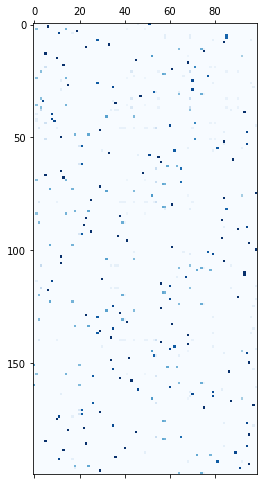

In [26]:
plt.matshow(tree_1_testprobs[:200, :100], cmap='Blues')
plt.show()

Speaking of visualization, yes, you can actually get a picture of the tree itself using this function. This uses a piece of software known as [Graphviz](https://graphviz.org/). It has bindings available for many languages, including Python. 

Make sure that `python-graphviz` is installed if you want the following to work.

```
conda install python-graphviz
```

In [27]:
from sklearn.tree import export_graphviz
import subprocess

In [28]:
def visualize_tree(tree, feature_names, dot_filename, png_filename):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecisionTree.
    feature_names -- list of feature names.
    """
    with open(dot_filename, 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", dot_filename, "-o", png_filename]
    try:
        subprocess.run(args=command, shell=True, check=True)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [29]:
visualize_tree(tree_1, features, "output/dt.dot", "output/dt.png")

In case you're wondering, the code above uses a Python list and the string `join` method to create the command that needs to get run by the `subprocess` module. Learn more about [spawning subprocesses from within Python code from the docs](https://docs.python.org/3/library/subprocess.html). Each element of the list (after the first) is a command line option for the `dot` program.

In [30]:
command = ["dot", "-Tpng", "output/dt.dot", "-o", "output/dt.png"]
" ".join(command)

'dot -Tpng output/dt.dot -o output/dt.png'

If the png file fails to get generated after calling `visualize_tree`, you can try running the command from the command prompt (in the same directory as this notebook). 

```
dot -Tpng output/dt.dot -o output/dt.png
```

In [31]:
from IPython.display import Image
Image("output/dt.png")

In case you're wondering, the code above uses a Python list and the string `join` method to create the command that needs to get run. Each element of the list (after the first) is a command line option for the `dot` program.

### A second tree
Let's try to grow a bigger tree by making the node splitting parameter smaller (set it to 2). Give this a shot yourself (copy-paste-edit is your friend). Look closely at the resulting score for the fitted model. What does this suggest about the model? Answer at bottom of notebook.

In [32]:
# 1. Create model object


# 2. Fit model and score the fit


# 3. Predict using test data


# 4. Create submission file


Let's go to Kaggle and submit these two models.

## Technique 2: Random forest
We've seen that random forests are generalizations of simple decision trees that can help avoid overfitting and result in a better predicter. It's an example of an "ensemble" method - we put a bunch of trees together and let them vote on the results. This is also known as *bagging*.

http://scikit-learn.org/stable/modules/ensemble.html

Look at how easy it is to use all the same ideas above to quickly try out this technique.

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
# 1. Create model
randforest_1 = RandomForestClassifier()

# 2. Fit model
randforest_1.fit(X, y)
print(f"Score: {randforest_1.score(X, y)}")

# 3. Predict using test data
randforest_1_testprobs = randforest_1.predict_proba(X_test)
df_randforest_1_testprobs = pd.DataFrame(randforest_1_testprobs, columns=targets, index=test_df.index)

# 4. Create submission file
df_randforest_1_testprobs.to_csv("output/randforest_1_submission.csv")

Score: 1.0


Whoa! We got a perfect score on the training data. What do you think about that? Let's go to Kaggle and see how we do on the test data.

## Technique 3: Logistic regression
There's a version of logistic regression known as *multinomial logistic regression* that can be used for classification problems with more than two classes. We will be exploring this method in greater detail in a subsequent notebook. 

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
# 1. Create model
logistic_1 = LogisticRegression()

# 2. Fit model
logistic_1.fit(X, y)
# Notice how we can control formatting in f-strings. This is just like we do with format() method.
print(f"Score: {logistic_1.score(X, y):.4f}")

# 3. Predict using test data
logistic_1_testprobs = logistic_1.predict_proba(X_test)
df_logistic_1_testprobs = pd.DataFrame(logistic_1_testprobs, columns=targets, index=test_df.index)

# 4. Create submission file
df_logistic_1_testprobs.to_csv("output/logistic_1_submission.csv")

Score: 0.6838


Not a very good score on the training data. Let's go see how we do on test.

## Technique 4: k-Nearest Neighbor
This is a simple technique and we should give it a try for this problem since we have all numeric data that has already been rescaled to be on a common scale. Remember, any ML technique that relies on computing a distance between vectors should have the data rescaled so that the distance metric isn't influenced by the units of measurement of the variables.

http://scikit-learn.org/stable/modules/neighbors.html

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [38]:
# 1. Create model
k = 5
knn_1 = KNeighborsClassifier(k)

# 2. Fit model
knn_1.fit(X, y)
print(f"Score: {knn_1.score(X, y):.4f}")

# 3. Predict using test data
knn_1_testprobs = knn_1.predict_proba(X_test)
df_knn_1_testprobs = pd.DataFrame(knn_1_testprobs, columns=targets, index=test_df.index)

# 4. Create submission file
df_knn_1_testprobs.to_csv("output/knn_1_submission.csv")

Score: 0.9293


## Technique 5: Put 'em together into an ensemble
While it may seem counter intuitive, combining a bunch of different models into an overall classifier by doing some sort of voting (for class prediction) or weighted averaging (for class probabilities) has worked pretty well in practice. In fact, state of the art weather forecasting models tend to be ensemble models.

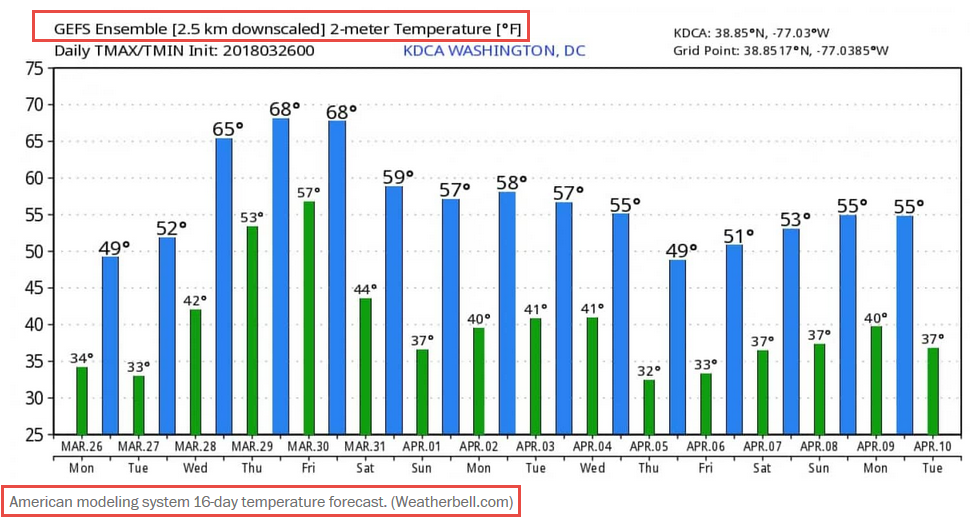

In [39]:
Image("weather_ensemble.png")

We'll gather up all the models we just fit and create a "soft voting" classifier using equal weights for the models. The "soft" style of voting equates to weighted averaging of the predicted probabilities where we get to specify the model weights.

* http://scikit-learn.org/stable/modules/ensemble.html
* http://scikit-learn.org/stable/modules/ensemble.html#votingclassifier

In [40]:
from sklearn.ensemble import VotingClassifier

In [41]:
# 1. Create model
ensemble_1 = VotingClassifier(estimators=[('tree_1', tree_1),
                                          ('tree_2', tree_1),
                                          ('randforest_1', randforest_1),
                                          ('logistic_1', logistic_1),
                                          ('knn_1', knn_1)], 
                              voting='soft', weights=[1.0, 1.0, 1.0, 1.0, 1.0])

# 2. Fit model
ensemble_1.fit(X, y)
print(f"Score: {ensemble_1.score(X, y):.4f}")

# 3. Predict using test data
ensemble_1_testprobs = ensemble_1.predict_proba(X_test)
df_ensemble_1_testprobs = pd.DataFrame(ensemble_1_testprobs, columns=targets, index=test_df.index)

# 4. Create submission file
df_ensemble_1_testprobs.to_csv("output/ensemble_1_submission.csv")

Score: 0.9848


Submit this to Kaggle to see how we did.

Try creating a second ensemble model with different weights to see if you can improve on your performance on the test data.

## Closing Thoughts

This was just a bit of review of sklearn, pandas, numpy, Jupyter notebooks, conda, submitting entries to Kaggle and some basic modeling workflows. Now we will take a closer look at some more advanced statistical/machine learning techniques including logistic regression models with regularization and boosted trees. We will also learn about analysis pipelines, setting up a good project structure with cookiecutters, version control with git and GitHub, and creating conda virtual environments.

## Answers

In [42]:
# 1. Create model
tree_2 = DecisionTreeClassifier(min_samples_split=2) # 2 is default too

# 2. Fit model and score the fit
tree_2.fit(X, y)
print(tree_2.score(X, y))

# 3. Predict using test data
tree_2_testprobs = tree_2.predict_proba(X_test)
df_tree_2_testprobs = pd.DataFrame(tree_2_testprobs, columns=targets, index=test_df.index)

# 4. Create submission file
df_tree_2_testprobs.to_csv("output/tree_2_submission.csv")

1.0


Whoa. We got a perfect score for our fitted model. We have definitely overfitted the model by allowing many more splits. Such a model is unlikely to perform well on new data.

My kaggle scores for the various models: (lower is better)

* tree_1: 8.61652
* tree_2: 10.52444
* randomforest_1: 0.69329
* logistic_1: 4.08320
* ensemble_1: 0.81326